# Electronic Structure Analysis of Materials

By Adriana J. Ladera

Center for Computational Science and Engineering, Massachusetts Institute of Technology

This is a tool to help analyze VASP calculations. It gets the total force on an atom, grabs info for VBM and CBM orbital partial charge calculations, and plots the electronic structure computed from VASP calculations of structures, specifically band structure, the density of states, and the Brillouin zones. All final figures are saved to a directory created during runtime called 'figures-and-data'.

## Import libraries

In [1]:
from analyzer import BSDosPlotter, EffectiveMass
from utils import ElectronicStructure
from utils.packages import *

## Getting the data from the .vasprunxml files and setting some parameters

In [2]:
root="/Users/adrianaladera/Desktop/MIT/research/mochas/VASP_calculations/sugar_mochas/galac_rtr/H-only_relax/"

band_xlim = [0,4] # CHANGE ME
ylim = [-2,5]
xlim = [-1,7]
dos_xlim = [-1,6]
line_width, font_size, marker = 3, 22, 22
savefig = False

## Density of States

[some blurb about DOS here] Like the band diagram, DOS also shows the band gap of materials.

Based on the DOSPlotter() module from Pymatgen, except much prettier YEEHAW

Takes in a DOSPlotter object and produces a matplotlib plot that plots the density of states by element in the material. The final figure is saved to a directory created during runtime called 'figures-and-data'.

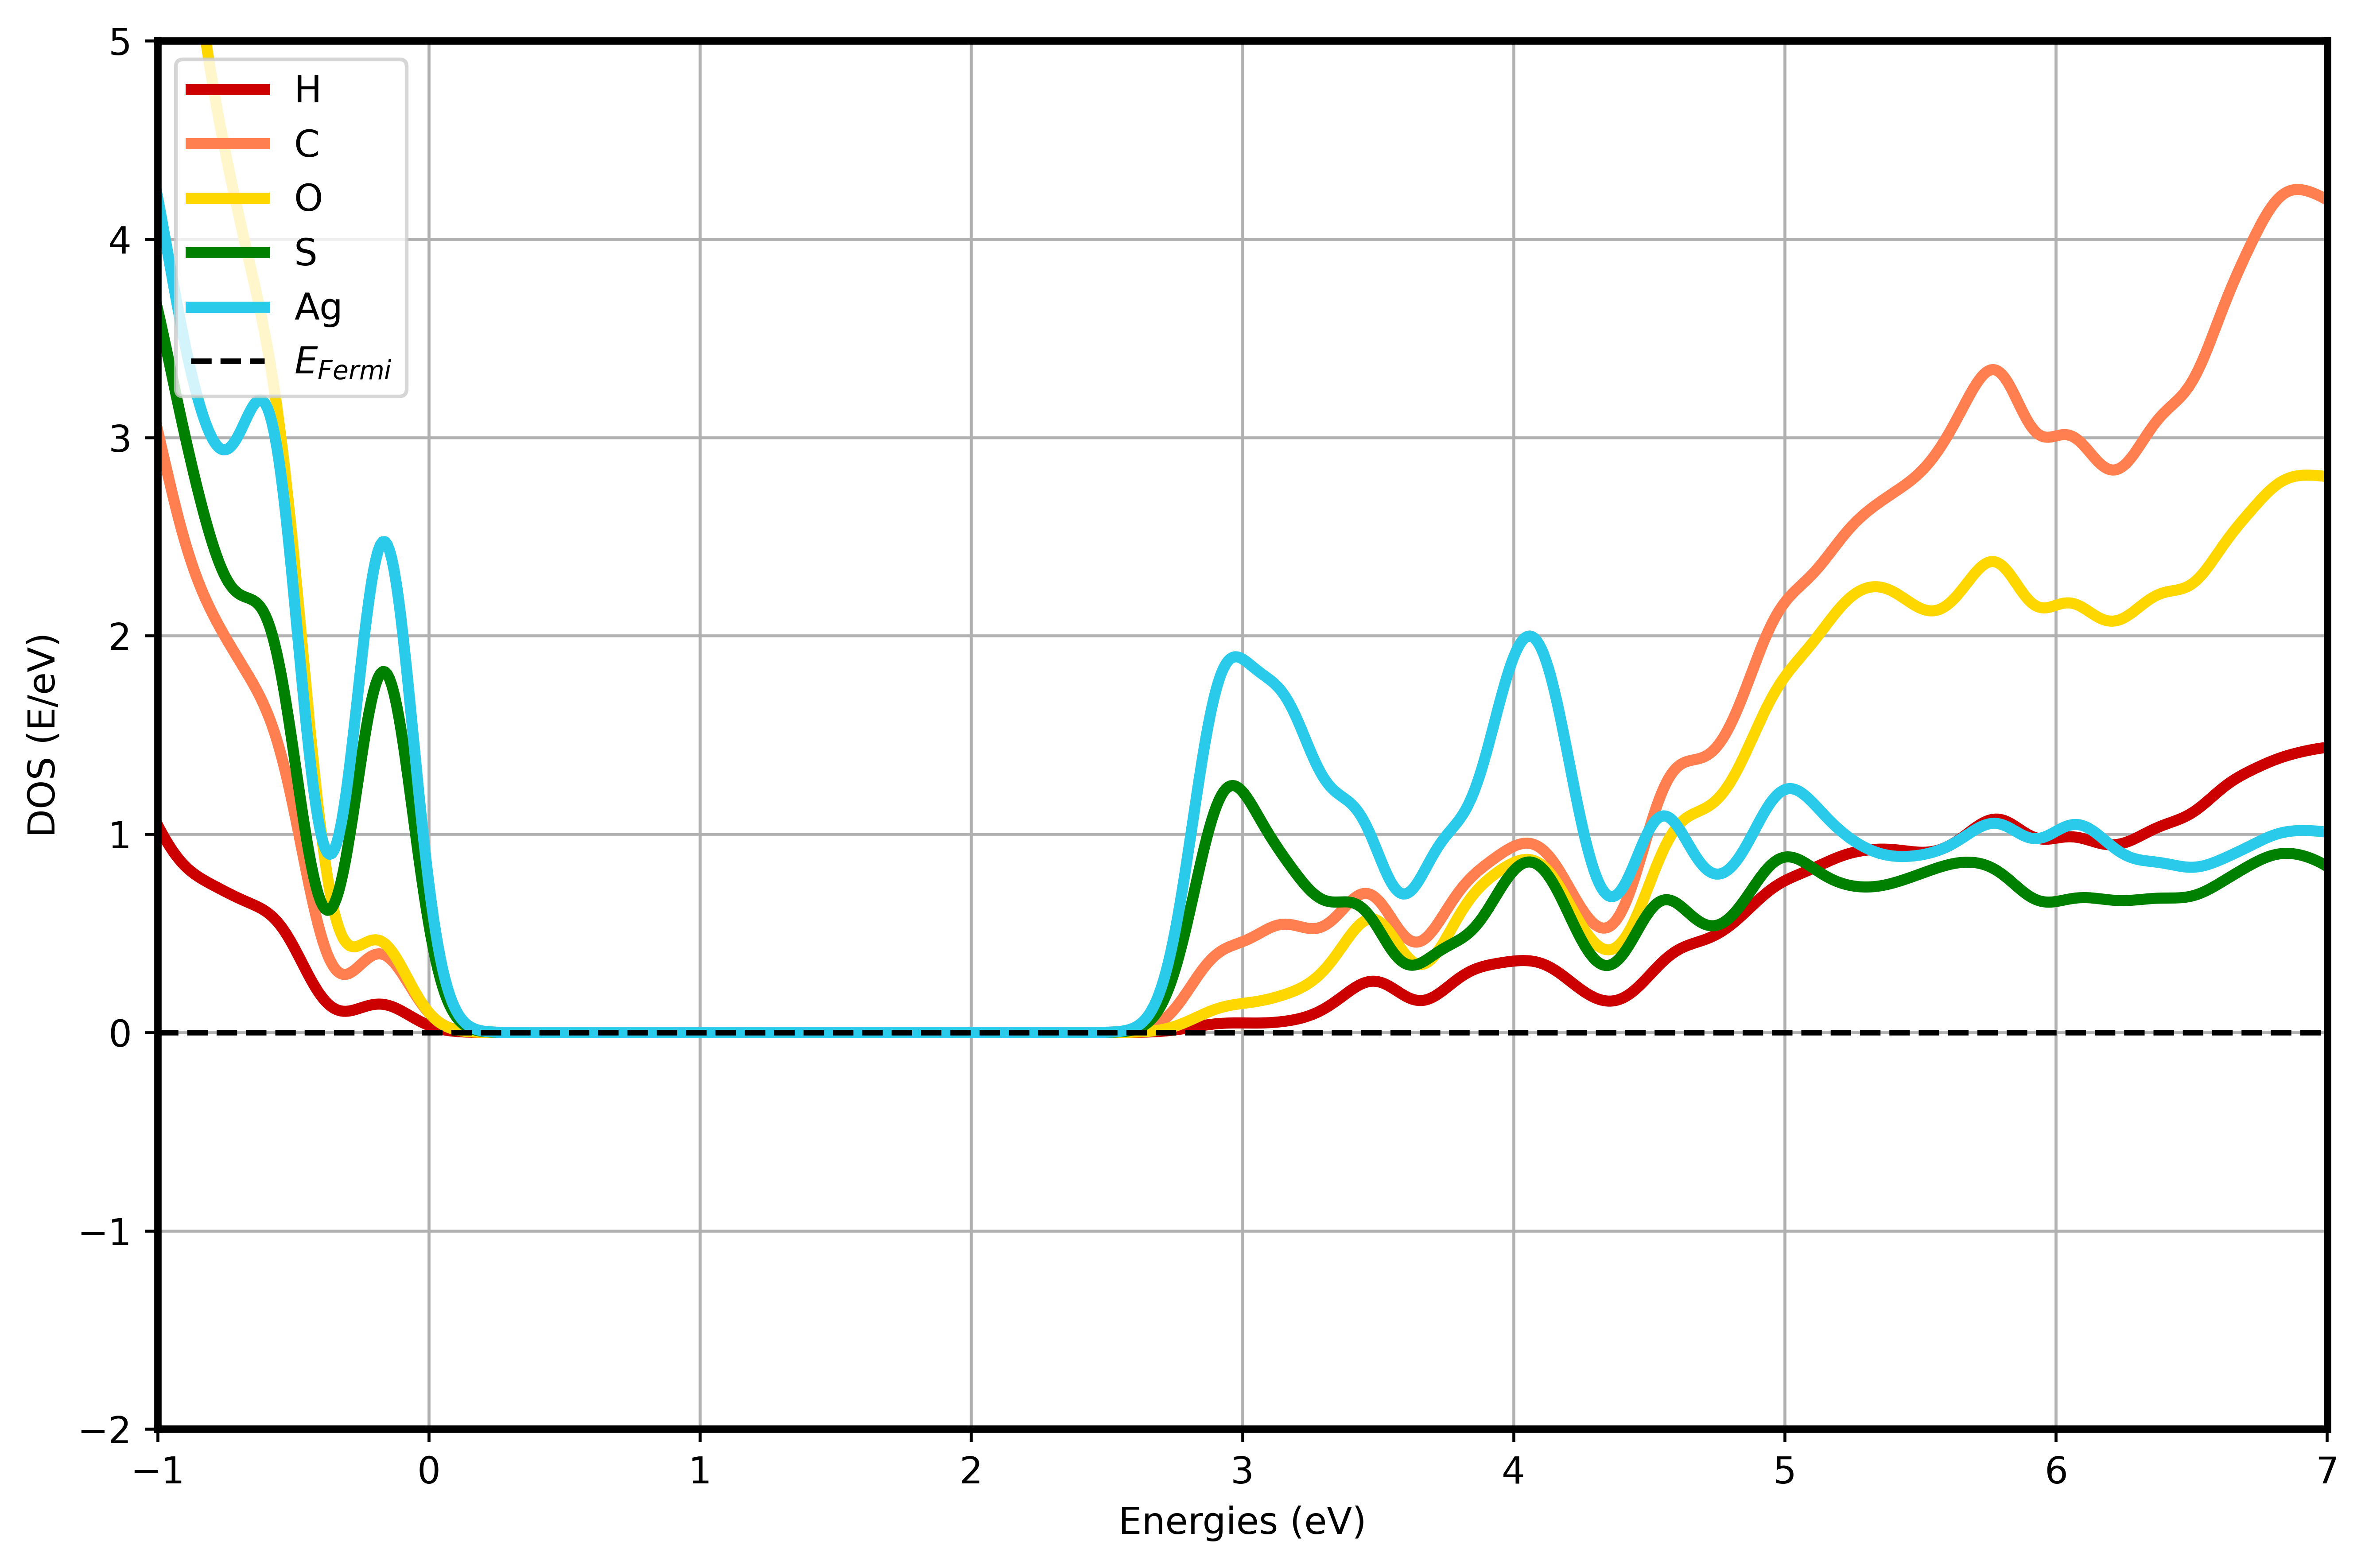

In [3]:
# dos
dosrun = Vasprun(f"{root}/dos/vasprun.xml", parse_dos=True)
dos = dosrun.complete_dos
dosplot = DosPlotter(sigma=0.1)
dosplot.add_dos_dict(dos.get_element_dos())

BSDosPlotter.sexy_dos_plot(root, dosplot, xlim=xlim, ylim=ylim, savefig=savefig)

## Getting orbital contributions to band gap

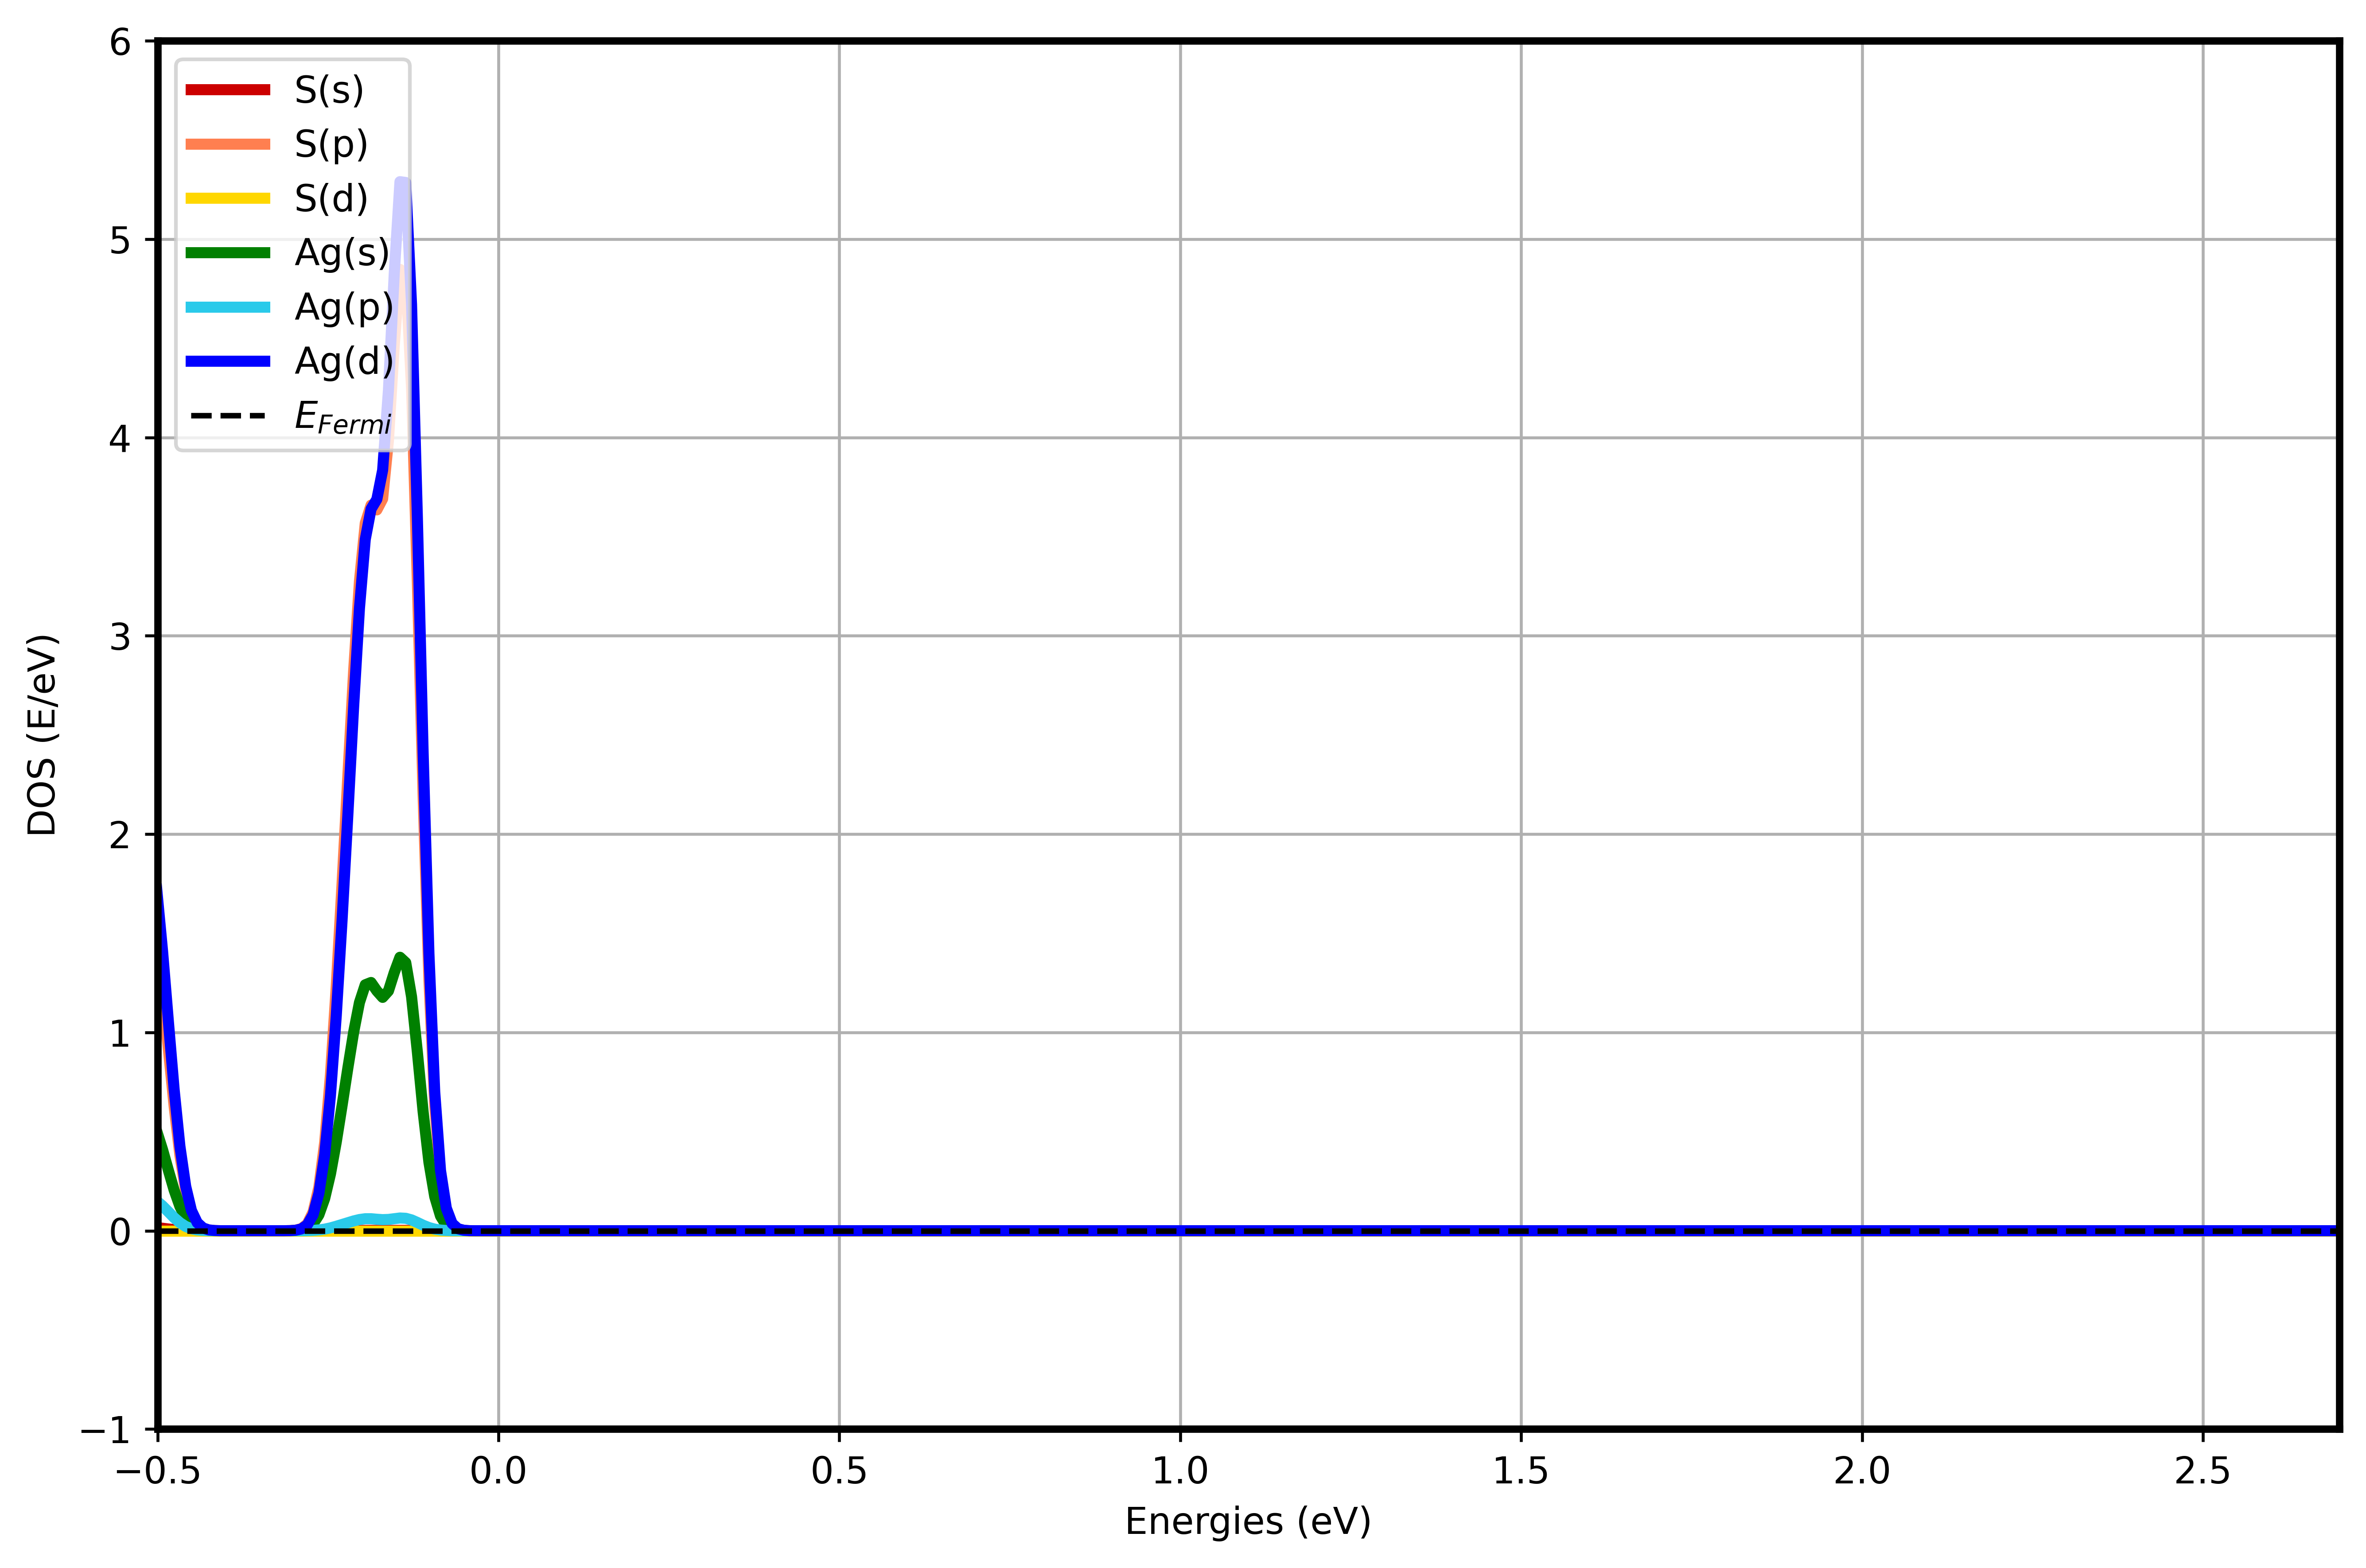

In [4]:
species_of_interest = ["Ag", "S"]

structure = Structure.from_file(f"{root}/scf/POSCAR")
species, pdos_list = [],[]

for atom in range(len(structure)):
    if str(structure[atom].species)[:-1] in species_of_interest and str(structure[atom].species)[:-1] not in species:
        species.append(str(structure[atom].species)[:-1])

# orbital contribution
orbitals = {'s': OrbitalType.s, 'p': OrbitalType.p, 'd':OrbitalType.d, 'f':OrbitalType.f}
result = Vasprun(f'{root}/dos/vasprun.xml', parse_potcar_file=False)
complete_dos = result.complete_dos
for s in species:
    pdos_list.append(complete_dos.get_element_spd_dos(s))
orbital_pdos = DosPlotter()
for pdos, s in zip(pdos_list, species):
    for orbital in orbitals:
        if orbitals[orbital] in pdos.keys():
            orbital_pdos.add_dos(f'{s}({orbital})', pdos[orbitals[orbital]])

BSDosPlotter.sexy_dos_plot(root, orbital_pdos, xlim=[-0.5, 2.7], ylim=[-1,6], savefig=savefig)

## Band Structure
Groups elements by color for the finalized band structure

- Red bands are inorganic interactions, black bands are organic interactions, and colors are interpolated
- **Valence band maxima, VBM (green)** $\rightarrow$ the valence band maxima from which electrons can jump
- **Conduction band minima, CBM (blue)** $\rightarrow$ the conduction band minima to which electrons from the valence band can traverse to
- **band gap** $\rightarrow$ the gap in energy, measured from the VBM to the CBM. The band gap can be either indirect, in which the VBM(s) and CBM(s) are not aligned at the same k-point, or direct, in which they are. When an electron traverses the band gap, a photon is emitted, though with indrect band gap materials this usually requires a change in momentum and is often aided by phonons. This means that direct band gap materials are also more efficient at emitting light.

BAND LABELS:
0 h
1 Γ
2 Γ
3 d$\mid$Γ
4 e$\mid$Γ
5 a$\mid$Γ
6 i$\mid$Γ
7 b$\mid$Γ
8 c


/Users/adrianaladera/Desktop/MIT/research/SolidState-dont-Evaporate/analyzer/BSDosPlotter.py:682: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=20)


(0.0, 2.9995000000000003)

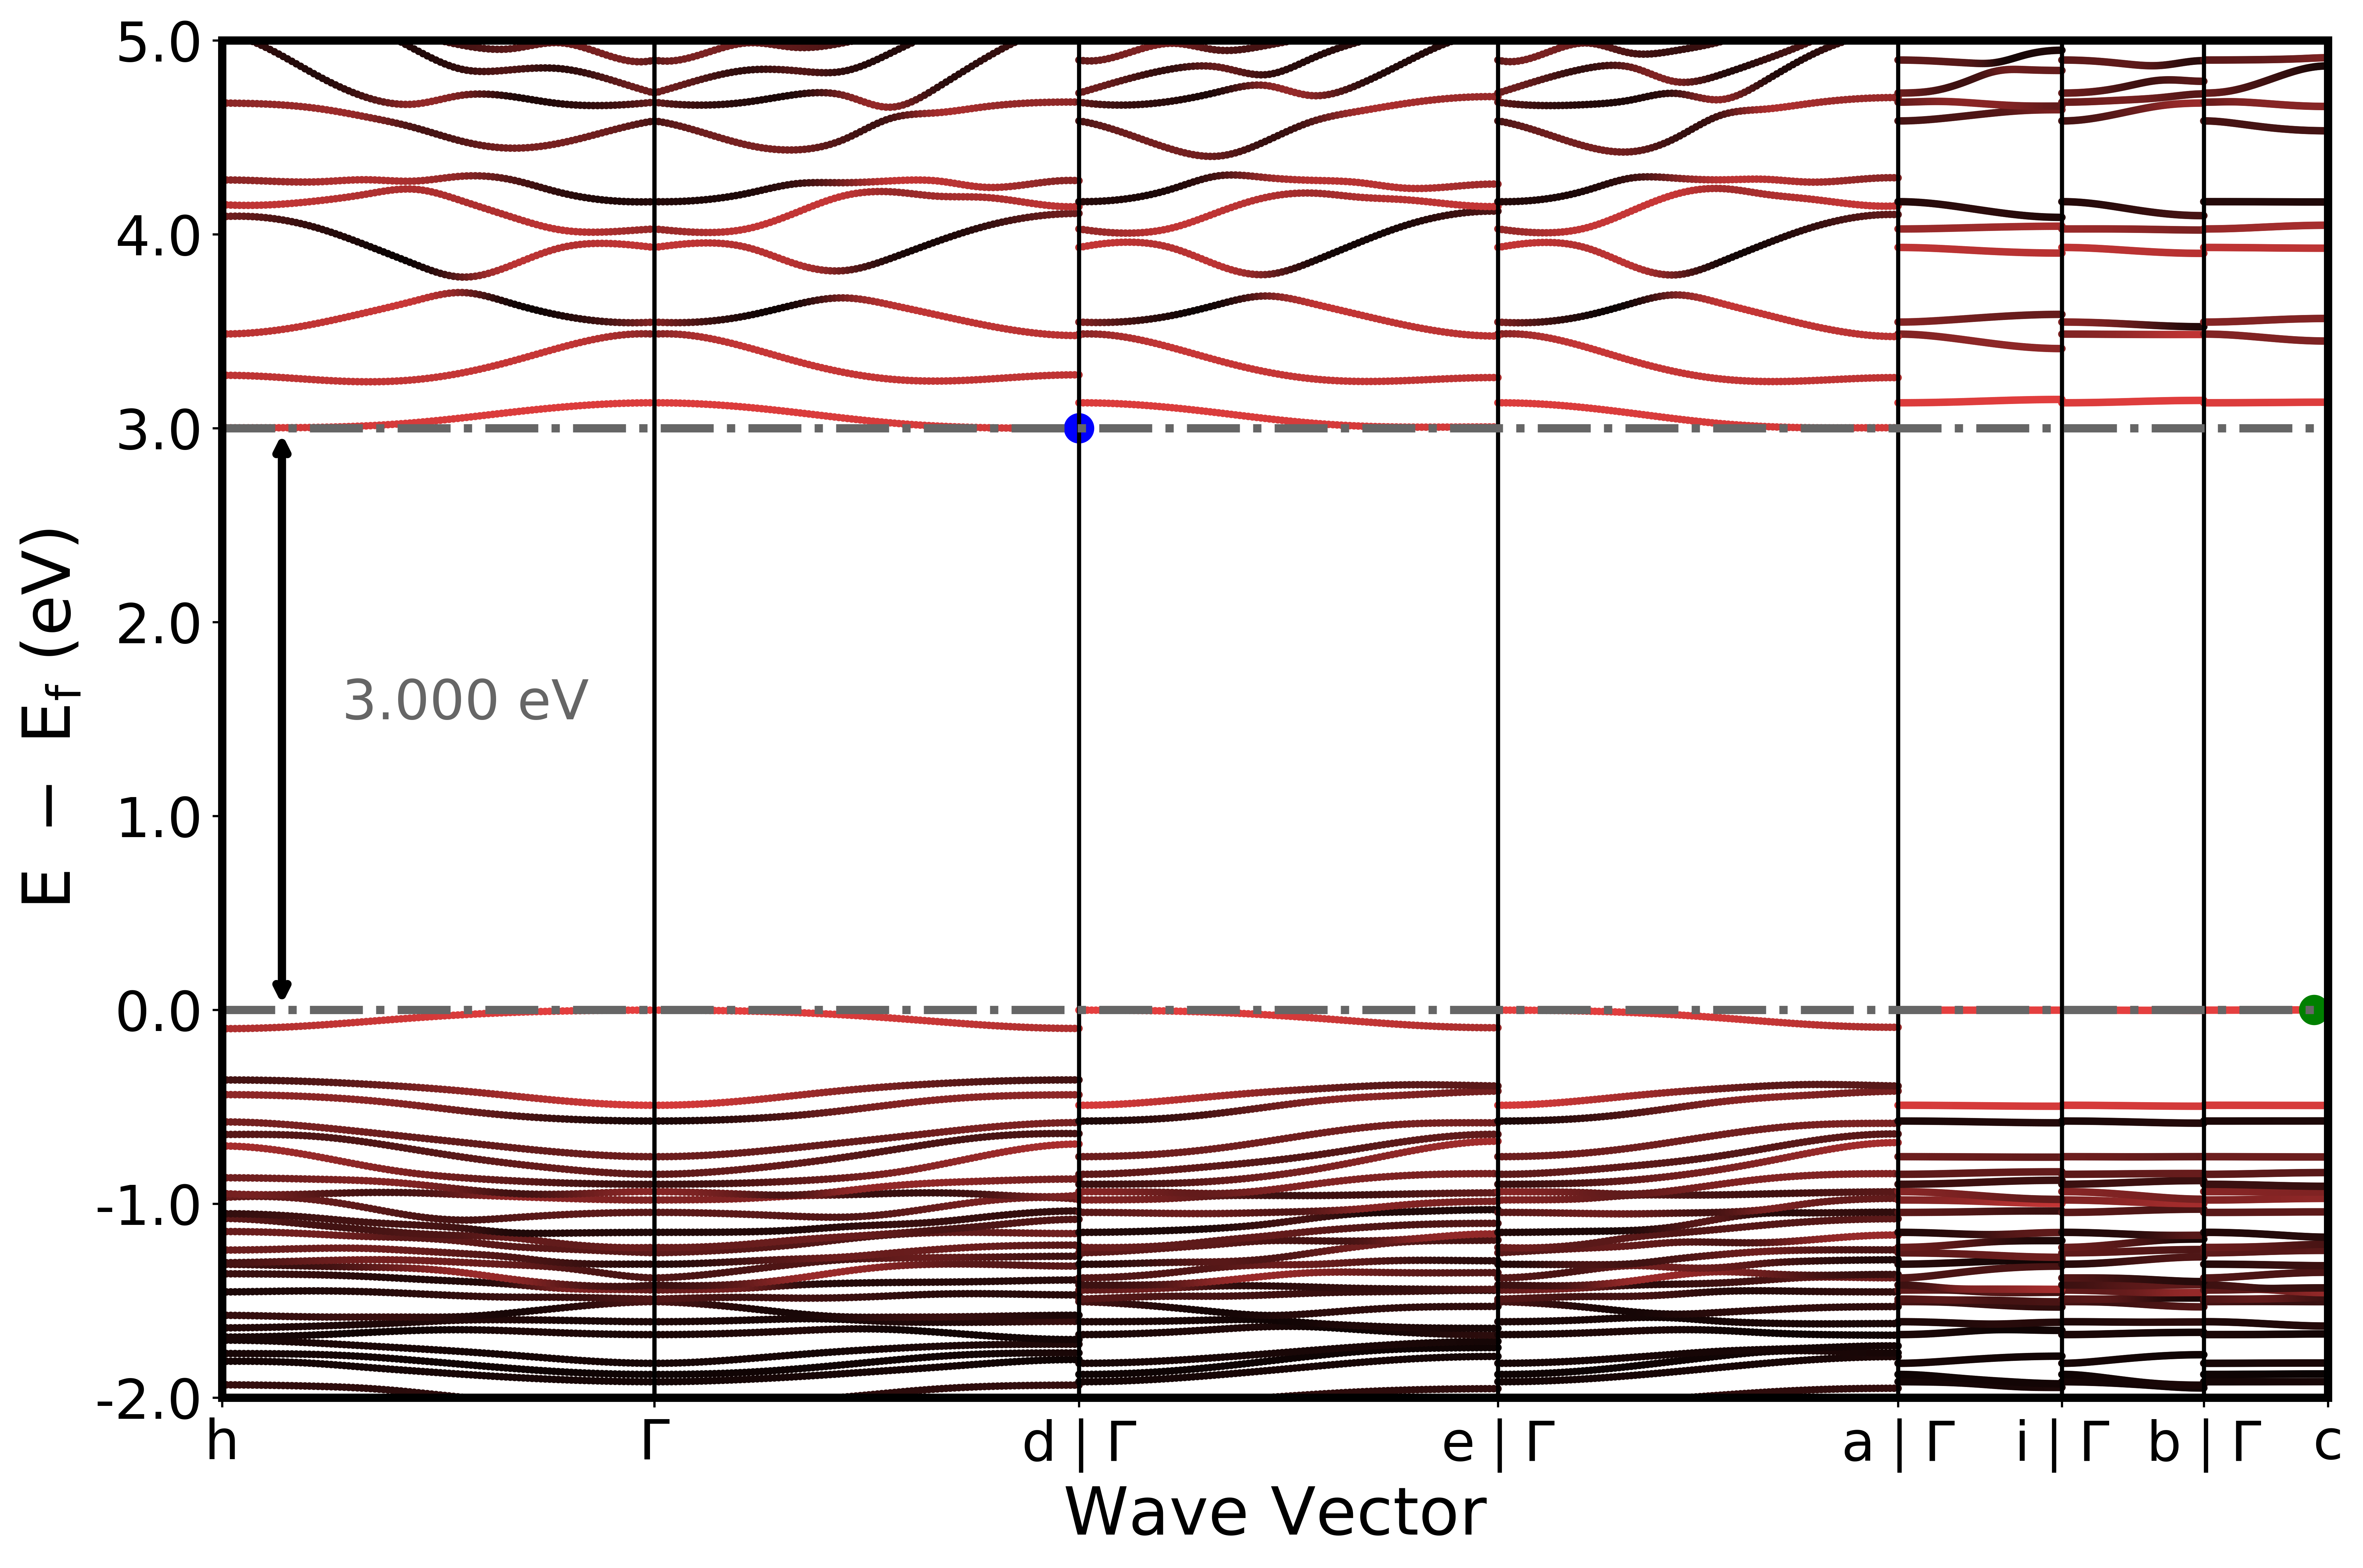

In [3]:
# bandz will make her dance 
bandrun = BSVasprun(f"{root}/band/vasprun.xml", parse_projected_eigen=True)
bs = bandrun.get_band_structure(f"{root}/band/KPOINTS")
bsp = BSPlotter(bs)

BSDosPlotter.color_bs_plotter(root, bsp, smooth=True, marker_size=3, ylim=ylim, savefig=False)

yourmom = get_band_data(root, bs)
yourmom

/Users/adrianaladera/Desktop/MIT/research/SolidState-dont-Evaporate/electronic_structure/BSDosPlotter.py:128: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a1.set_xticklabels(np.arange(dos_xlim[0], dos_xlim[1]), fontsize=20)
/Users/adrianaladera/Desktop/MIT/research/SolidState-dont-Evaporate/electronic_structure/BSDosPlotter.py:129: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a1.set_yticklabels(np.arange(ylim[0], ylim[1]), fontsize=20)


BAND LABELS:
0 h
1 Γ
2 Γ
3 d$\mid$Γ
4 e$\mid$Γ
5 a$\mid$Γ
6 i$\mid$Γ
7 b$\mid$Γ
8 c


/Users/adrianaladera/Desktop/MIT/research/SolidState-dont-Evaporate/electronic_structure/BSDosPlotter.py:324: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a0.set_yticklabels(a0.get_yticks(), fontsize=20)


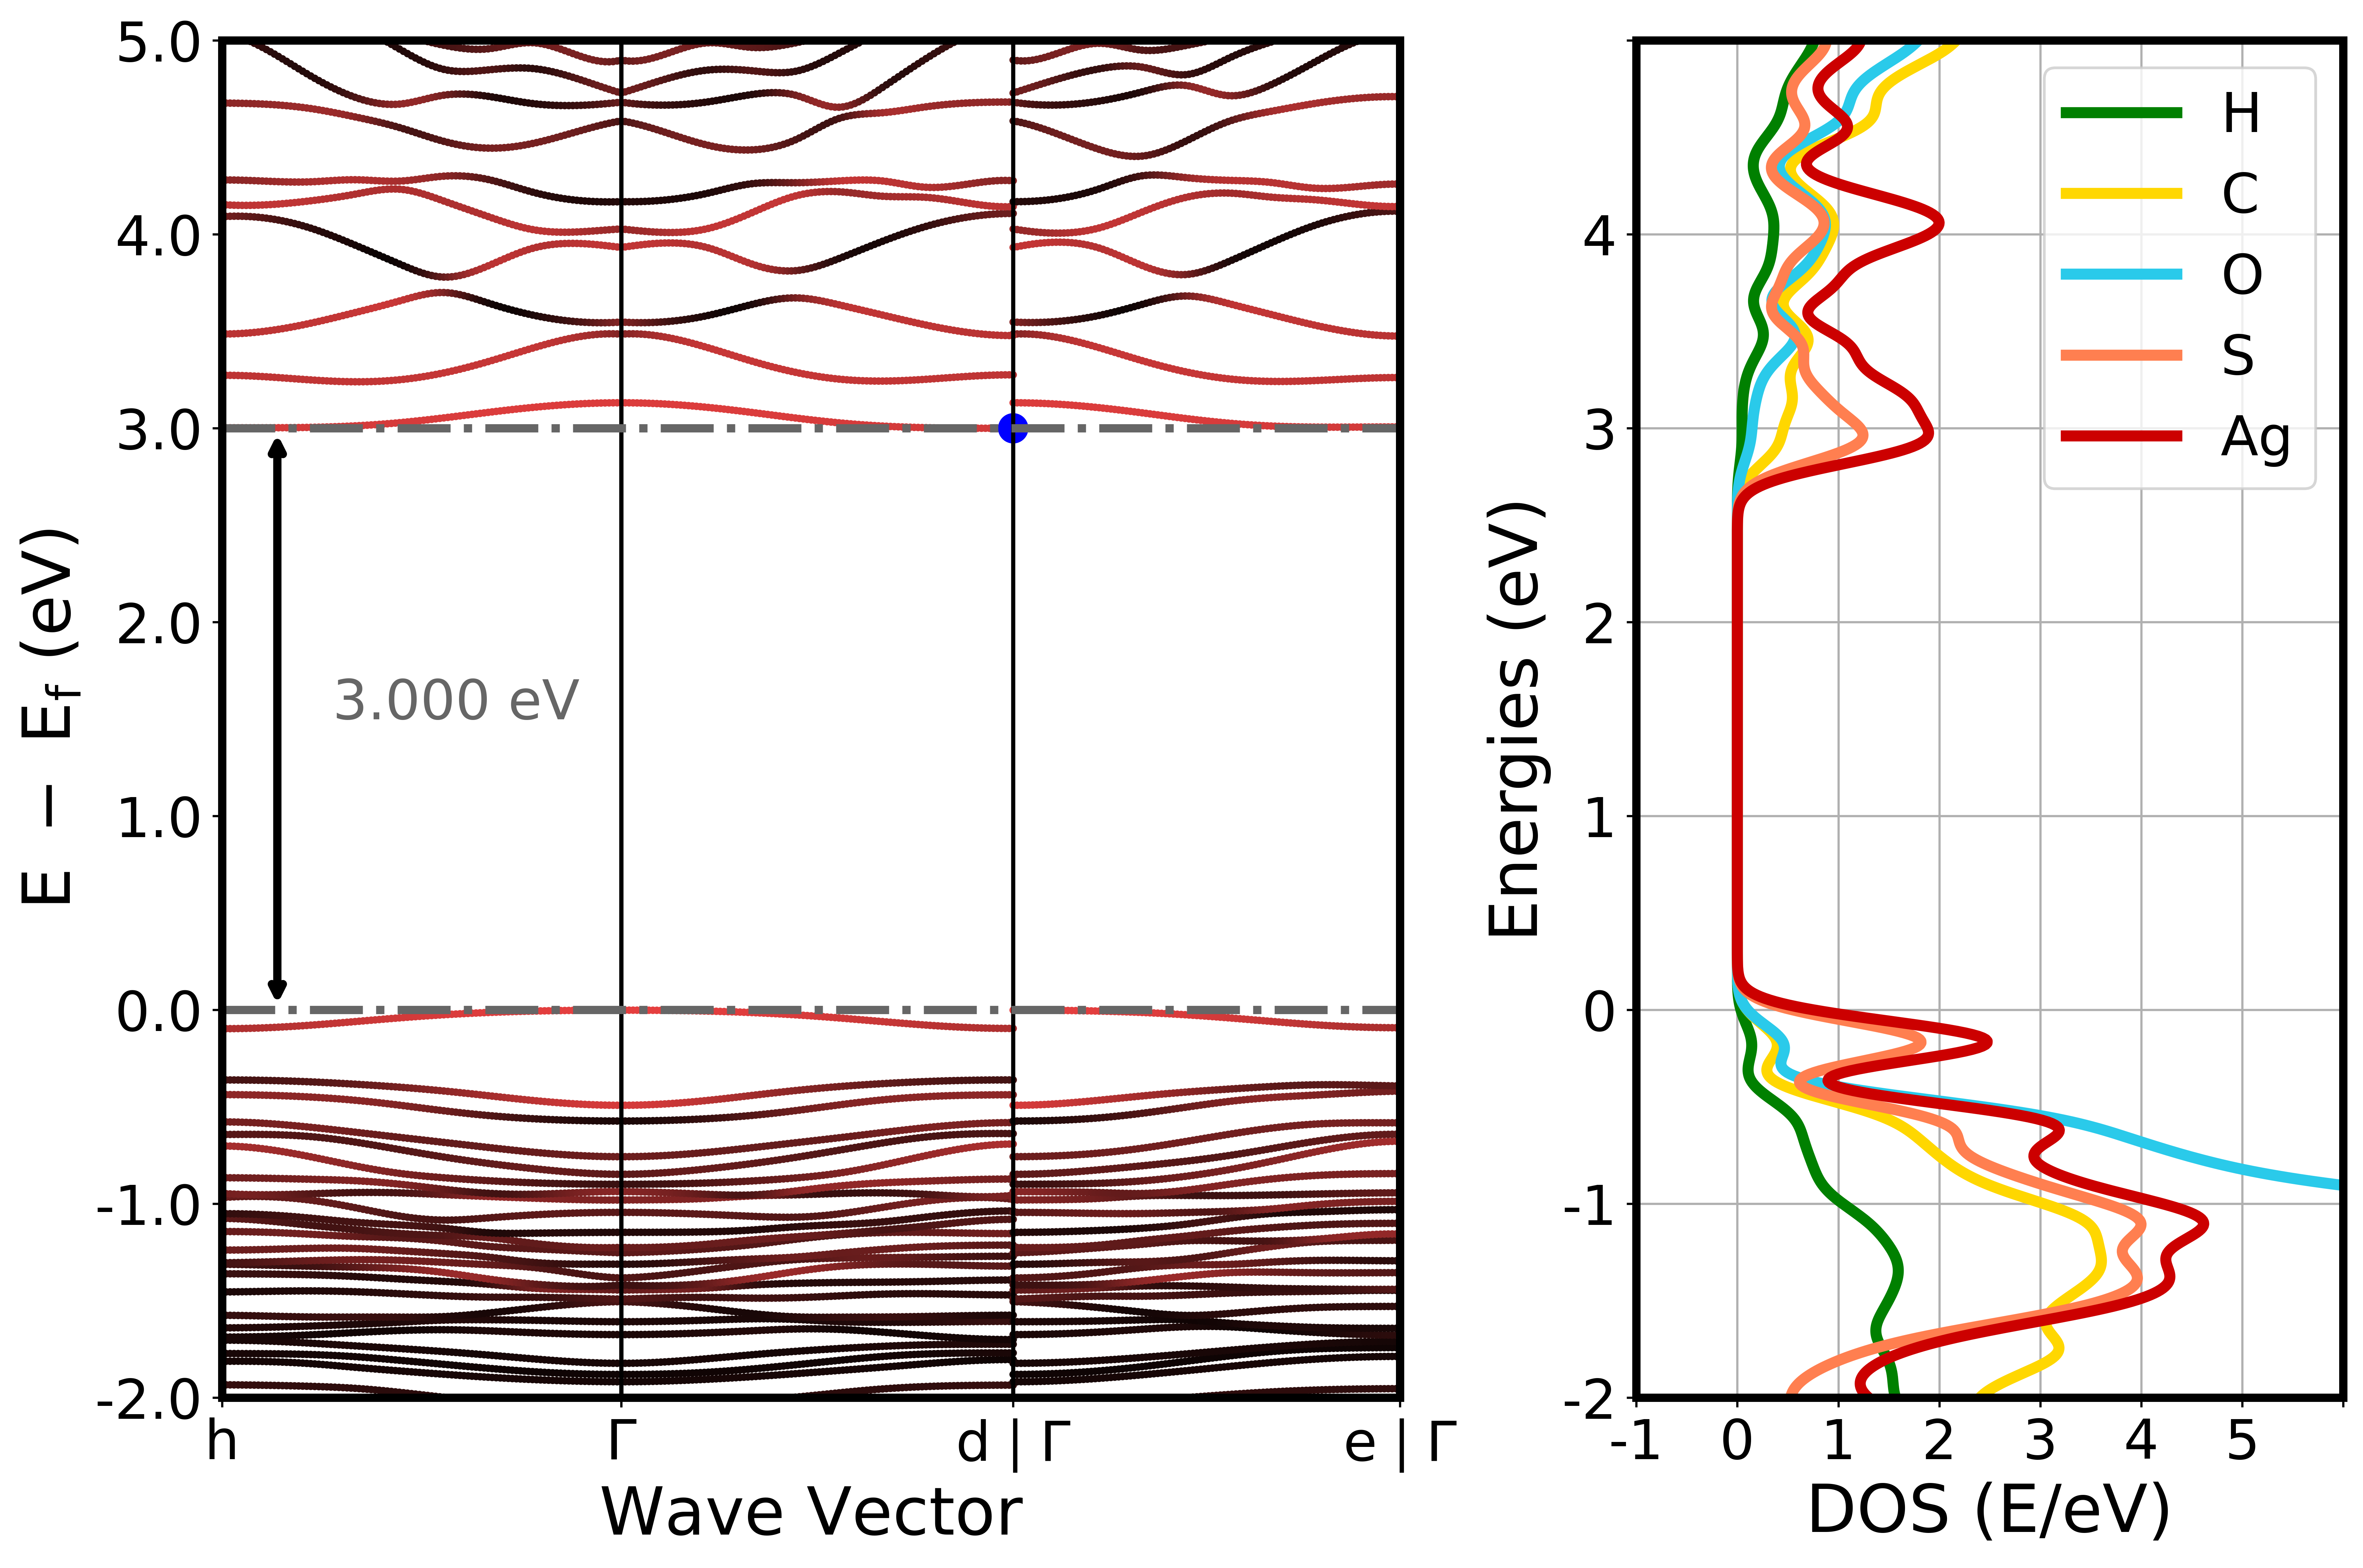

In [18]:

band_labels, vbm, cbm = BSDosPlotter.color_bs_dos_plotter(root, bsp, dosplot, smooth=True, marker_size=3, ylim=ylim, dos_xlim=dos_xlim, band_xlim=band_xlim, savefig=savefig)

## Effective mass

In [6]:
data = inputs.DataVasp(f"{root}/band/OUTCAR", f"{root}/band/PROCAR")
settings = inputs.Settings(extrema_search_depth=0.075, energy_range=0.25)
vbm, cbm = float(yourmom["vbm"]), float(yourmom["cbm"])

segments = effmass_from_vbm_cbm(data, settings, vbm, cbm)

vbm     cbm    eFermi  bandgap              transition
0  0.7802  3.7797  0.956616   2.9995  (0.000,0.000,-0.444)-d